In [1]:
!python -m spacy download es_core_news_md > a

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import nltk
nltk.download('punkt')
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance  #euclidean dsitance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


cargar datos 

En colab suele tener un error la siguiente linea. Si aparece un error de es_core_news_md, reiniciar el entorno de ejecucion y correr nuevamente las celdas, evitando correr la primera. 
`!python -m spacy download es_core_news_md > a`

In [2]:
nlp = spacy.load('es_core_news_md')

Conectar con Drive, teniendo guardado en una carpeta Mineria el corpus "lavoztextodump.txt"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/MyDrive/Mineria/'
filename = "lavoztextodump.txt"
text_file = open(drive_path+filename, "r")
dataset = text_file.read()
text_file.close()

In [5]:
#Eliminamos los separadores de notas, para que "-" no cuente como un parrafo 
new_dataset = dataset.replace('-\n', '')

In [12]:
#Solo tomamos los primeros 1000000 de caracteres, para que lo pueda procesar spacy
doc = nlp(new_dataset[:1000000])

In [51]:
new_dataset.count("ufeff1")

0

Funcion para separar en parrafors, ya que no hay una propia de spacy

In [13]:
def paragraphs(document):
    start = 0
    for token in document:
        if token.is_space and token.text.count("\n") >= 1:
            yield document[start:token.i]
            start = token.i
    yield document[start:]

In [15]:
#sents = [sent for sent in doc.sents if len(sent) > 10]

words_lemmas = []
for sent in doc.sents:
    for word in sent:
        if word.is_alpha:
            words_lemmas.append(word.lemma_)
            
counts = Counter(words_lemmas)

In [16]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
threshold_w = 10
threshold_c = 50

for par in paragraphs(doc):
  for word in par:
    w = word.lemma_
    if not word.is_alpha or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    tag = "TAG__" + word.tag_
    if not tag in features:
        features[tag] = 0
    features[tag] += 1

    tripla = "TRIPLA__" + w +  "__" + word.dep_ + "__" + word.head.lemma_
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

#incluir el contexto en oracion tambien, y reducir el valor en el de parrafo
    for other_word in par:
      if other_word == word:
        continue
      if counts[other_word.lemma_] > threshold_c:
        if other_word.like_num:
          context = "NUM__"
        else:
          context = other_word.lemma_
        if not context in features:
            features[context] = 0
        features[context] += 1

    word_id += 1

    dicc[w] = features

In [17]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [18]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [19]:
matrix_normed = matrix / matrix.max(axis=0)

In [20]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [21]:
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [22]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [23]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

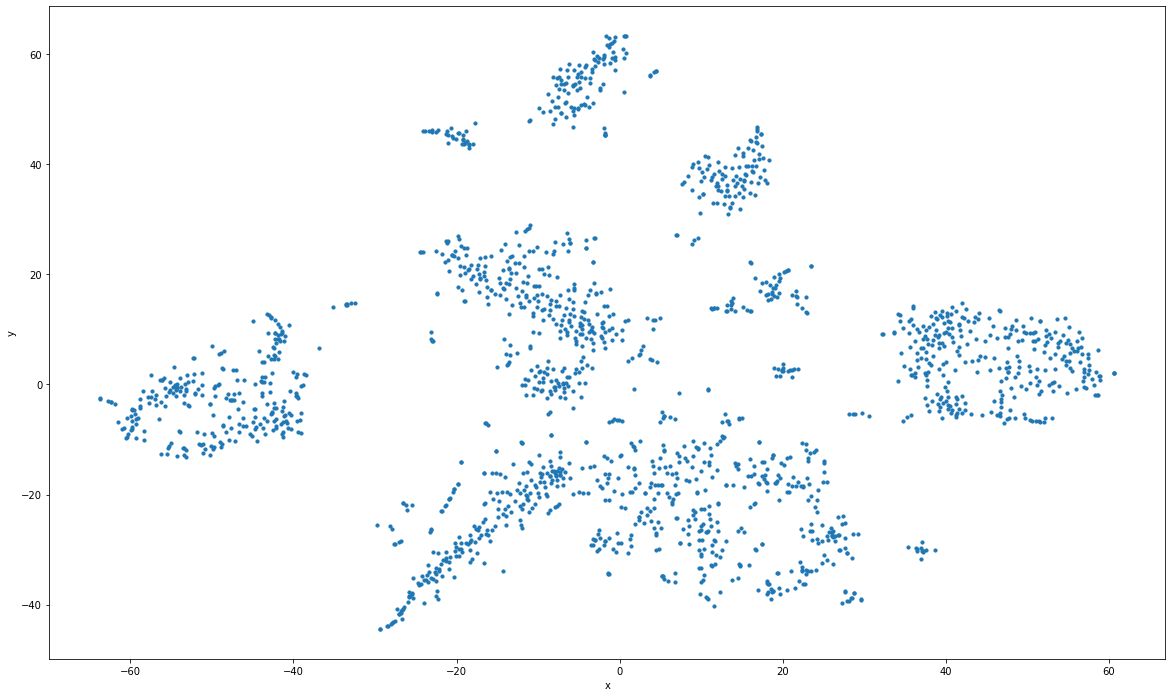

In [24]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [48]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 5))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=8)

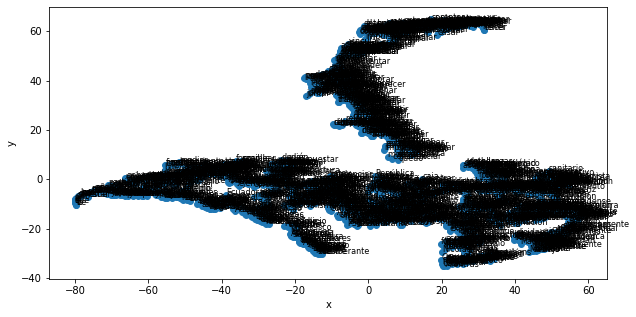

In [49]:
plot_region(x_bounds=(-1000, 1000), y_bounds=(-1000, 4000))

In [27]:
def clustering(k, matrix_):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix_, True)
    return clusters

In [28]:
clusters = clustering(125, red_matrix)

In [29]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

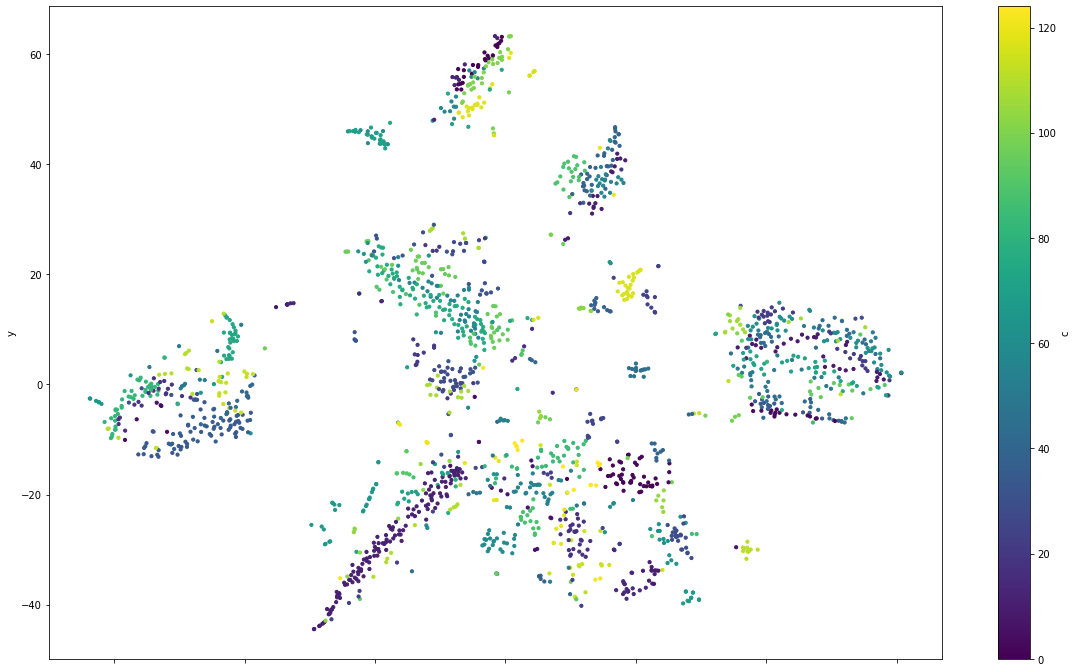

In [30]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [31]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

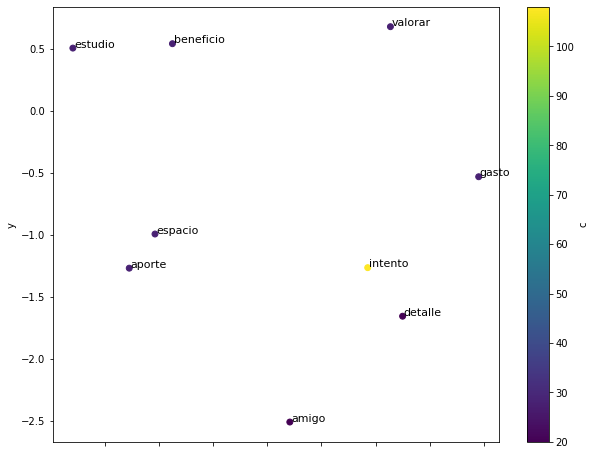

In [32]:
plot_region_cluster(x_bounds=(-10, -8), y_bounds=(-3,1))

In [33]:
# Stopwords
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["de"]]]
print(printer)

['Lo', 'que', 'a', 'lo', 'el', 'y', 'no', 'se', 'sin', 'ni', 'Se', 'en', 'de', 'Hoy', 'del', 'sino', 'tan', 'les', 'Qué', 'siempre', 'pero', 'ya', 'más', 'A', 'No', 'comer', 'parir', 'los', 'con', 'ese', 'al', 'Sin', 'sólo', 'También', 'por', 'Los', 'si', 'Es', 'El', 'cada', 'ahora', 'o', 'aunque', 'nunca', 'En', 'Y', 'La', 'ayer', 'Así', 'Si', 'desde', 'Que', 'Ese', 'porque', 'le', 'Pero', 'su', 'este', 'recién', 'muy', 'Por', 'hoy', 'durante', 'sobrar', 'mediante', 'De', 'quien', 'Las', 'hasta', 'Entre', 'Uno', 'nuestro', 'luego', 'Aunque', 'antes', 'apenar', 'Ahora', 'Esa', 'Son', 'atrás', 'e', 'Además', 'todavía', 'Cada', 'Tras', 'casi', 'Allí', 'Según', 'Con', 'Para', 'Nosotros', 'según', 'Como', 'Una', 'además', 'Desde', 'Hasta', 'allí', 'Tampoco', 'Incluso', 'aun', 'Un', 'Fue', 'demás', 'Esto', 'Luego', 'hacia', 'Esta', 'ante', 'Finalmente', 'tampoco', 'Más', 'finalmente', 'Al', 'aquí', 'Sus', 'Antes', 'Durante', 'Ayer', 'tras', 'Su', 'quizá', 'Mientras', 'prácticamente', 'segur

In [34]:
# Días de la semana
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["lunes"]]]
print(printer)

['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'domingo']


In [50]:
#entrevistar
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["entrevistar"]]]
print(printer)

['visitar', 'entrevistar', 'denunciar', 'demandar']


In [36]:
# Funcionarios públicos
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["ejecutivo"]]]
print(printer)

['junto', 'secundario', 'edilicio', 'extranjero', 'operativo', 'universitario', 'preventivo', 'sanitario', 'numeroso', 'opositor', 'ejecutivo', 'humano', 'minero', 'cuadrar', 'urbano', 'religioso', 'práctico', 'concreto', 'presunto', 'serio', 'cubano']


In [37]:
# Funcionarios públicos
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["institución"]]]
print(printer)

['institución', 'obrar', 'escuela', 'refacción', 'clase', 'plaza', 'propiedad', 'instalación', 'exportación', 'agrupación', 'vivienda', 'víctima', 'aula', 'herramienta']


In [38]:
seen = []
cluster = [[]]
i = 0 
for word in key_words:
  if word in seen:
    continue
  seen.append(word)
  cluster.append([word])
  for w2 in key_words:
    if w2 in seen:
      continue
    if clusters[key_words[w2]] == clusters[key_words[word]]:
        seen.append(w2)
        cluster[i].append(w2)
  i+=1

In [39]:
for clus in cluster:
  print(clus)

['que', 'a', 'lo', 'el', 'y', 'no', 'se', 'sin', 'ni', 'Se', 'en', 'de', 'Hoy', 'del', 'sino', 'tan', 'les', 'Qué', 'siempre', 'pero', 'ya', 'más', 'A', 'No', 'comer', 'parir', 'los', 'con', 'ese', 'al', 'Sin', 'sólo', 'También', 'por', 'Los', 'si', 'Es', 'El', 'cada', 'ahora', 'o', 'aunque', 'nunca', 'En', 'Y', 'La', 'ayer', 'Así', 'Si', 'desde', 'Que', 'Ese', 'porque', 'le', 'Pero', 'su', 'este', 'recién', 'muy', 'Por', 'hoy', 'durante', 'sobrar', 'mediante', 'De', 'quien', 'Las', 'hasta', 'Entre', 'Uno', 'nuestro', 'luego', 'Aunque', 'antes', 'apenar', 'Ahora', 'Esa', 'Son', 'atrás', 'e', 'Además', 'todavía', 'Cada', 'Tras', 'casi', 'Allí', 'Según', 'Con', 'Para', 'Nosotros', 'según', 'Como', 'Una', 'además', 'Desde', 'Hasta', 'allí', 'Tampoco', 'Incluso', 'aun', 'Un', 'Fue', 'demás', 'Esto', 'Luego', 'hacia', 'Esta', 'ante', 'Finalmente', 'tampoco', 'Más', 'finalmente', 'Al', 'aquí', 'Sus', 'Antes', 'Durante', 'Ayer', 'tras', 'Su', 'quizá', 'Mientras', 'prácticamente', 'seguramente

embeddings

In [40]:
from gensim.models import Word2Vec

sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(dataset[:1000000])]
model = Word2Vec(sentences, min_count=10)

In [41]:
model.wv.most_similar('Brasil', topn=10)

[('Estados', 0.9996103048324585),
 ('cuatro', 0.9995788931846619),
 ('zona', 0.9995625615119934),
 ('Rousseff', 0.9995525479316711),
 ('2007', 0.9995445013046265),
 ('30', 0.9994955062866211),
 ('inversión', 0.9994625449180603),
 ('ocho', 0.9994244575500488),
 ('parte', 0.9993839263916016),
 ('firma', 0.9993736743927002)]

In [42]:
from sklearn.decomposition import TruncatedSVD
# reducing data to 10 dimensions
svd = TruncatedSVD(n_components=2)
svd_matrix = svd.fit_transform(red_matrix)

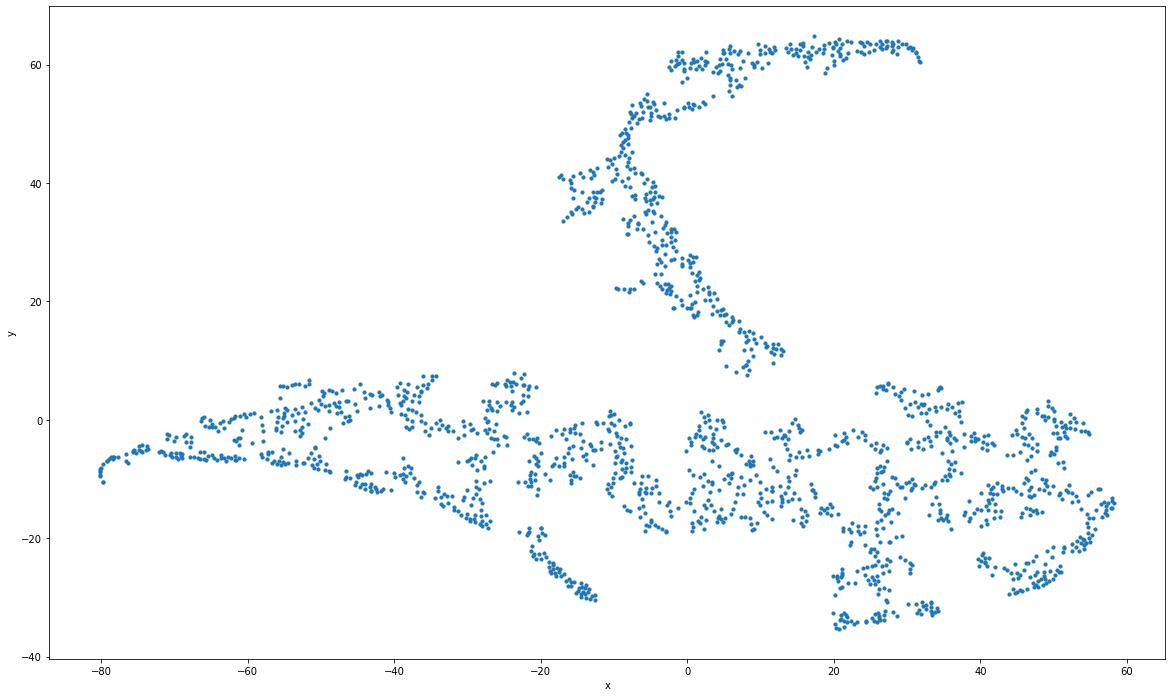

In [43]:
# t-SNE is used to visualize our high-dimensional svd_matrix
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(svd_matrix)

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [44]:
# k-means with cosine distances is used for clustering
n_clusters = 150
clusters_svd = clustering(n_clusters, svd_matrix) # cambiar clustering funcion

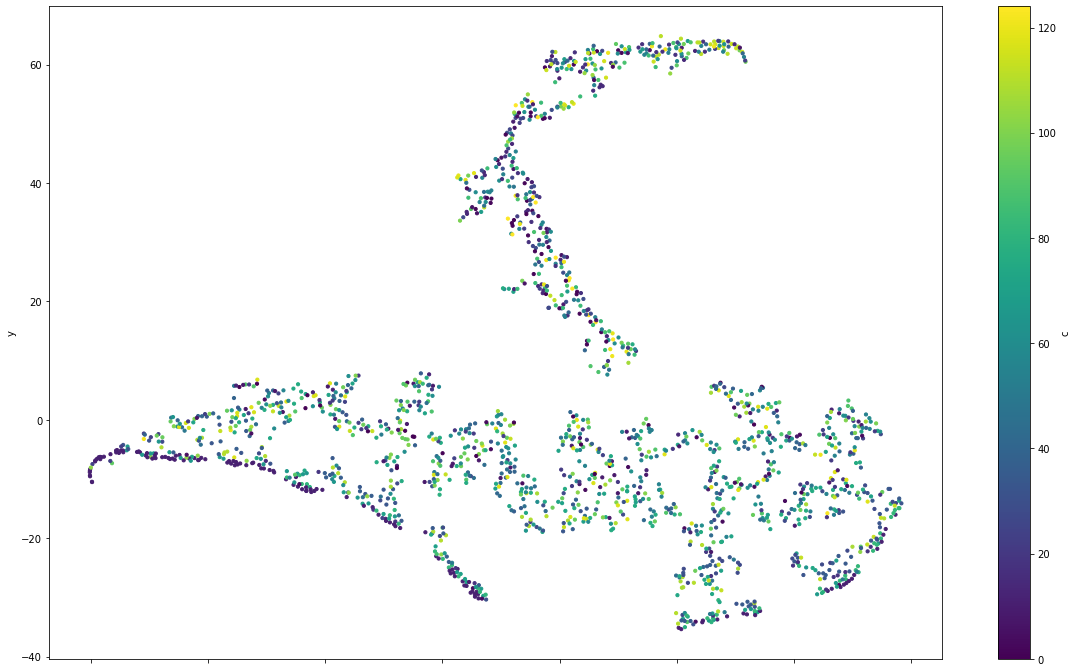

In [45]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [46]:
def get_clusters(l):
  l_cluster = [lemma for lemma in key_words if clusters[key_words[lemma]] == clusters[key_words[l]]]
  print(f'Cluster for {l}:')
  print(f'\t{l_cluster}\n')

In [47]:
get_clusters("lunes")

Cluster for lunes:
	['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'domingo']

